# Workflows

For now we mainly looked at models in isolation. However, the true power of probabilistic modelling lies in its ability to move beyond the "one-model-fits-all" idea, but rather create a variety of models and connect or compare them in various ways. Indeed, even for a normal use cases, we already typically go up to a dozen models or more. In more complex experimental designs, which are becoming every more common, this can easily go up to a hundred or more.

In [4]:
%load_ext autoreload
%autoreload 2
import latenta as la
import lacell as lac
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Even in relatively simple use cases, managing different models, storing them across sessions, and let them depend on each other can be a pain. To make this easier, we created a small workflow manager in the `laflow` package. It borrows elements from other workflow managers such as snakemake or nextflow. However, it is much more focused on interactivity, modularization and model inheritance that, all concepts very central to the modelling we're doing here.

The core tasks of laflow is:
- **Persistence**, to store sure models and its derivatives on disk
- **Model inheritance**, creation of similar models that only differ in certain aspects
- **Connecting data**, to explicitely define what a model needs and where it gets this

In [5]:
import laflow as laf

We'll use the same dataset as [before](./1-variables).

In [6]:
import scanpy as sc

adata = la.data.load_myod1()
adata.obs["log_overexpression"] = np.log1p(adata.obs["overexpression"])
adata.var["label"] = adata.var["symbol"]
adata.raw = adata

## Persistence

The basis of laflow is the {class}`~laflow.Flow` class. Each instance we create is associated with a particular folder on disk, starting from a given root directory. We work from a temporary directory in these tutorials, but in real life use cases this root is typically  your project's root directory or one of its subdirectories.

In [7]:
import tempfile
import pathlib

project_root = pathlib.Path(tempfile.TemporaryDirectory().name)
project_root.mkdir()
laf.set_project_root(project_root)  # sets the default project root

We can then create a {class}`~laflow.Flow` object as follows. Because we set the default root for this python session, we don't have to provide this any longer.

In [8]:
dataset = laf.Flow("dataset")
dataset.path  # the path associated with this flow

PosixPath('/tmp/tmp83k7b1hj/dataset')

This folder will store information on each object, links to other objects or flows, and the objects themselves if they are labeled as persistent. We can store a python object inside a flow by simply assigning it:

In [9]:
dataset.adata = adata

Because python objects are by default persistent, the `adata` object was saved in the folder as a pickle. Along with it is a info json file which is used internally to keep track which type of object it is and how it was created.

In [10]:
!ls -lh {dataset.path}

total 6.4M
-rw-r--r-- 1 wsaelens updepla  155 Oct  4 22:45 adata.info
-rw-r--r-- 1 wsaelens updepla 6.4M Oct  4 22:45 adata.pkl


When working in IPython environments (e.g. Jupyter), we can always check what contents a flow object has as follows:

In [11]:
dataset

Even if we restart our session (simulated here by removing the flow object), we can always retrieve it by recreating a flow object in the correct folder:

In [12]:
if "dataset" in globals():
    del dataset
dataset = laf.Flow("dataset")

In [13]:
dataset

## Modularization & building workflows

To make our workflows more modular, we use Python's OOP system to systematically let certain flows depend on each other and share common code. For example, a dataset in our example would be defined as follows:

In [55]:
class Dataset(laf.Flow):
    default_name = "dataset"
    adata = laf.PyObj()

We can initialize this dataset as before. Note that we do not provide a name in this case as we want to use the default "dataset" name:

In [56]:
dataset = Dataset(adata = adata)

In [57]:
dataset

We can now define our model as another Flow. It contains a link to the dataset flow, along with three methods that create, infer and interpret the model:

In [58]:
class ConstantModel(laf.Flow):
    # sets the default name
    default_name = "constant"

    # lets the flow know that it can contain a link to another flow called dataset
    dataset = laf.FlowObj()

    # lets the flow know that it can expect a model_initial object, that is not persistent
    model_initial = laf.LatentaObj(persistent=False)

    # creates a particular step, that expects adata as input, and that outputs model initial
    # note the way we access the adata from the dataset object
    @laf.Step(
        laf.Inputs(adata = dataset.adata),
        laf.Outputs(model_initial)
    )
    def create_model(self, output, adata):
        # define the model as before
        overexpression = la.Fixed(
            adata.obs["log_overexpression"], label="overexpression"
        )
        transcriptome = lac.transcriptome.Transcriptome.from_adata(dataset.adata)
        foldchange = transcriptome.find("foldchange")

        foldchange.overexpression = la.links.scalar.Constant(
            overexpression, definition=foldchange.value_definition
        )
        
        # apart from each input, the step function will also receive an output object
        # you should put any expected outputs in this object either by assigning it 
        # or by using the update function
        return output.update(model_initial = transcriptome)

    # the (final) model is persistent by default
    model = laf.LatentaObj()
    
    # another step, that receives the model_initial as input, and outputs the model
    @laf.Step(
        laf.Inputs(model_initial),
        laf.Outputs(model)
    )
    def infer_model(self, output, model_initial):
        # infer the model as before
        # we first clone the model_initial so that we do not overwrite it
        model = model_initial.clone()
        with model.switch(la.config.device):
            inference = la.infer.svi.SVI(
                model, [la.infer.loss.ELBO()], la.infer.optim.Adam(lr=5e-2)
            )
            trainer = la.infer.trainer.Trainer(inference)
            trace = trainer.train(10000)

        return output.update(model = model)

    # define our three posteriors, each one with a "db" argument
    # this will make sure that any model objects are not stored in the posterior,
    # but are rather extracted each time from the model object as defined earlier
    transcriptome_observed = laf.LatentaObj(db = {model})
    overexpression_observed = laf.LatentaObj(db = {model})
    overexpression_causal = laf.LatentaObj(db = {model})
    
    @laf.Step(
        laf.Inputs(model),
        laf.Outputs(transcriptome_observed, overexpression_observed, overexpression_causal)
    )
    def interpret(self, output, model):
        transcriptome_observed = la.posterior.vector.VectorObserved(model)
        transcriptome_observed.sample(5)
        output.transcriptome_observed = transcriptome_observed

        overexpression = model.find("overexpression")

        overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
        overexpression_observed.sample(5)
        output.overexpression_observed = overexpression_observed

        overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
            overexpression,
            model,
            interpretable=model.p.mu.expression,
            observed=overexpression_observed,
        )
        overexpression_causal.sample(10)
        overexpression_causal.sample_random(10)
        overexpression_causal.observed
        overexpression_causal.sample_empirical()
        output.overexpression_causal = overexpression_causal
        
        # we directly assigned the outputs to each 
        return output

Note that we typically define these flows in a separate file as a python module, and import them in our notebooks or other interactive sessions.

In [59]:
model = ConstantModel()

In [60]:
model

In [61]:
model.dataset = dataset

In [62]:
model

In [63]:
model.dataset

In [64]:
model.create_model()

▶️ | constant/create_model                                                                               
✅ | constant/create_model                                                                               


In [65]:
model

In [66]:
model.infer_model()

▶️ | constant/infer_model                                                                                


  0%|                                                                                                         …

✅ | constant/infer_model                                                                                


In [67]:
model.interpret()

▶️ | constant/interpret                                                                                  


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

✅ | constant/interpret                                                                                  


In [68]:
model

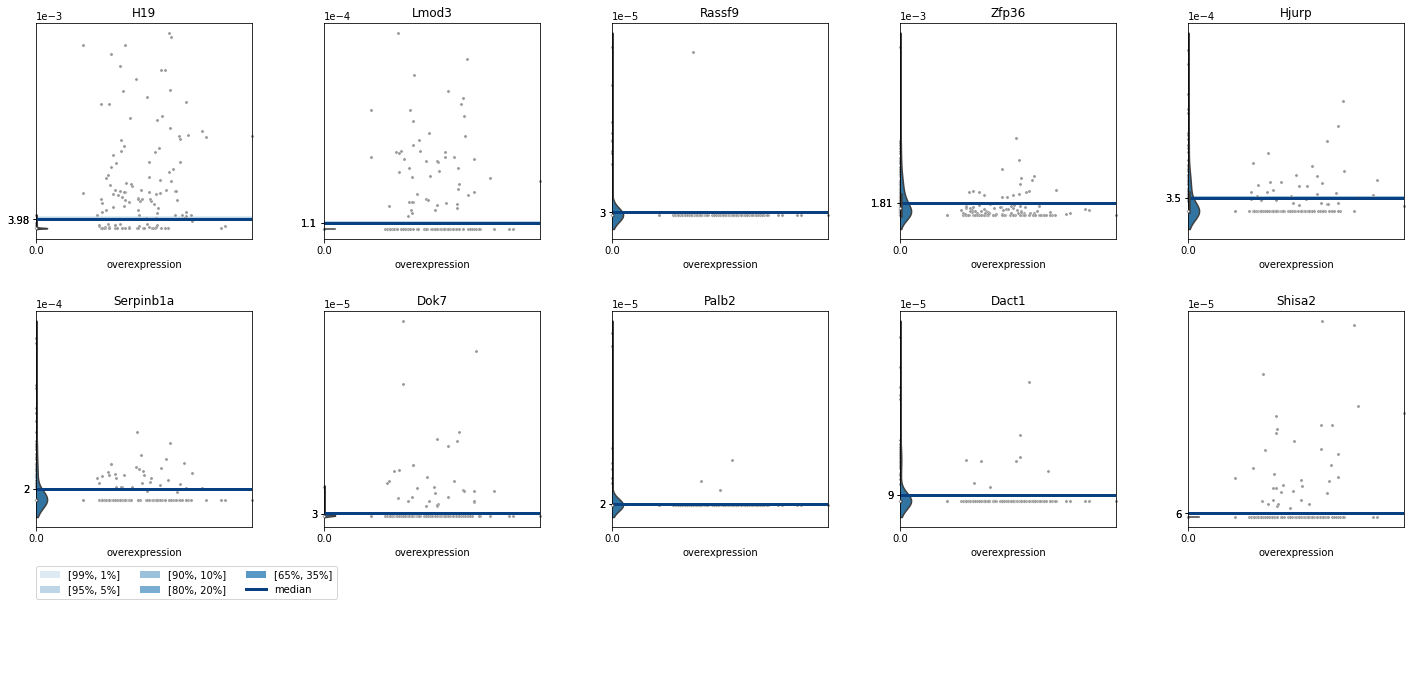

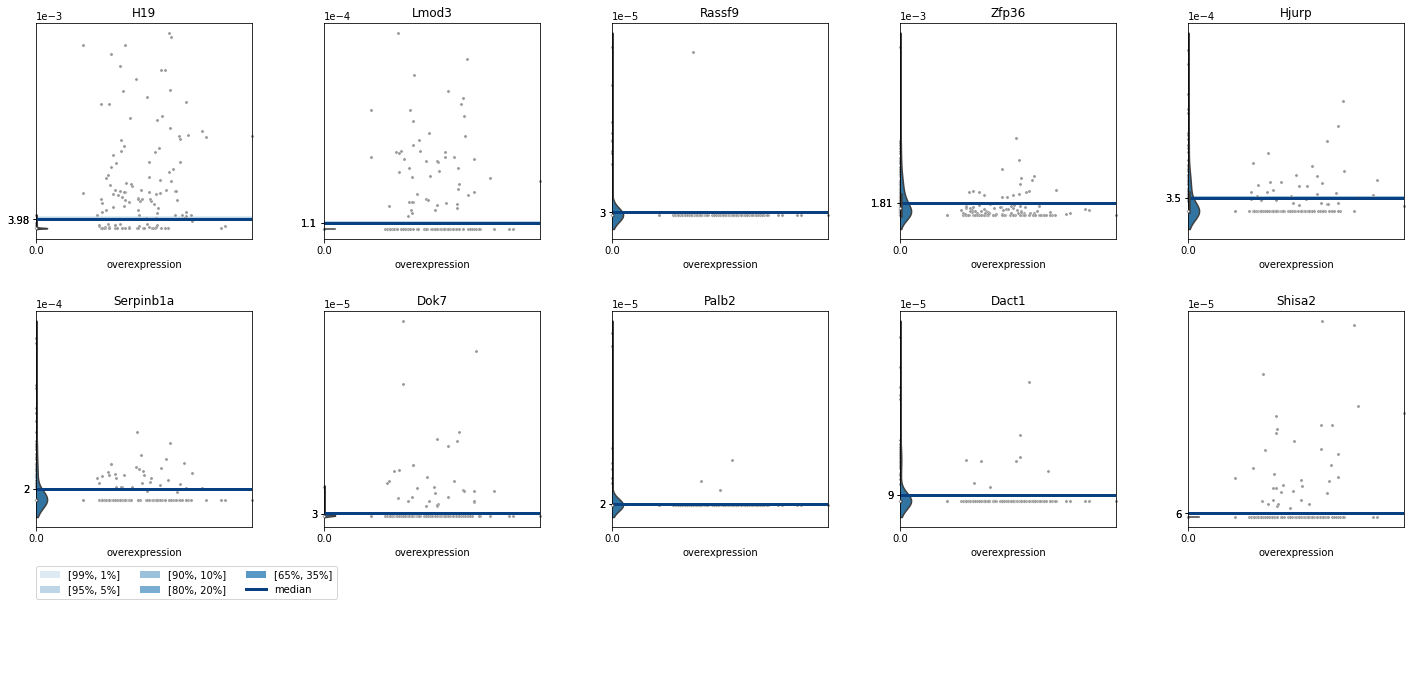

In [69]:
model.overexpression_causal.plot_features()

We can now define our spline and linear models through inheritance, and only change the bits that are different. In this case, this is at the level of model creation:

In [70]:
class LinearModel(ConstantModel):
    # we change the default name, as to make sure this model is put in a different folder
    default_name = "linear"

    def create_model(self, output, adata):
        # we can access the inherited function by adding a "_" at the end
        output = super().create_model_(output, adata)
        
        # extract the model_initial from the output
        model_initial = output.model_initial
        
        # now we can further adapt the model to our wish
        foldchange = model_initial.find("foldchange")
        overexpression = model_initial.find("overexpression")

        foldchange.overexpression = la.links.scalar.Linear(
            overexpression, a=True, definition=foldchange.value_definition
        )
        
        # again return the output
        # because we only adapted the model inplace, we do not need to update the output
        return output


class SplineModel(ConstantModel):
    default_name = "spline"

    def create_model(self, output, adata):
        output = super().create_model_(output, adata)
        
        model_initial = output.model_initial

        foldchange = model_initial.find("foldchange")
        overexpression = model_initial.find("overexpression")

        foldchange.overexpression = la.links.scalar.Spline(
            overexpression, definition=foldchange.value_definition
        )

        return output

In [71]:
model = LinearModel(dataset=dataset)
model.create_model()
model.infer_model()
model.interpret()

▶️ | linear/create_model                                                                                 
✅ | linear/create_model                                                                                 
▶️ | linear/infer_model                                                                                  


  0%|                                                                                                         …

/tmp/tmpvunj_qpt/constant/model.pkl: 558.5 KiB / 11.2 MiB = 0.049, 0:02
/tmp/tmpvunj_qpt/constant/overexpression_causal.pkl: 513.8 KiB / 16.1 MiB = 0.031, 0:02


✅ | linear/infer_model                                                                                  
▶️ | linear/interpret                                                                                    


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

✅ | linear/interpret                                                                                    


In [72]:
model = SplineModel(dataset=dataset)
model.create_model()
model.infer_model()
model.interpret()

▶️ | spline/create_model                                                                                 
✅ | spline/create_model                                                                                 
▶️ | spline/infer_model                                                                                  


  0%|                                                                                                         …

/tmp/tmpvunj_qpt/linear/model.pkl: 578.1 KiB / 11.3 MiB = 0.050, 0:02


✅ | spline/infer_model                                                                                  
▶️ | spline/interpret                                                                                    


/tmp/tmpvunj_qpt/linear/overexpression_causal.pkl: 7,867.7 KiB / 16.1 MiB = 0.477, 3.6 MiB/s, 0:04


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

✅ | spline/interpret                                                                                    


/tmp/tmpvunj_qpt/spline/model.pkl: 684.2 KiB / 11.6 MiB = 0.058, 0:02


## Building from existing workflows

lacell not only contains classes that help with model creation, but also with workflow creation. For example, if we're working with transcriptomics data, we will often inherit from {class}`~lac.transcriptome.TranscriptomeDataset` and {class}`~lac.transcriptome.TranscriptomeModel`:

In [96]:
project_root = pathlib.Path(tempfile.TemporaryDirectory().name)
project_root.mkdir()
laf.set_project_root(project_root)  # sets the default project root

In [97]:
dataset = lac.transcriptome.TranscriptomeDataset("dataset2")

It contains information from one modality, namely the transcriptome:

In [98]:
dataset.transcriptome

In [99]:
dataset.transcriptome.from_adata(adata = adata)

▶️ | dataset2/transcriptome/from_adata                                                                   
✅ | dataset2/transcriptome/from_adata                                                                   


In [100]:
dataset.transcriptome

In [101]:
dataset

In [102]:
class ConstantModel(lac.transcriptome.TranscriptomeModel):
    default_name = "constant"
    dataset = laf.FlowObj()

    def create_model(self, output, X, obs, var):
        output = super().create_model_(output, X, obs, var)
        
        transcriptome = output.model_initial
        
        # define the model as before
        overexpression = la.Fixed(
            obs["log_overexpression"], label="overexpression"
        )
        foldchange = transcriptome.find("foldchange")

        foldchange.overexpression = la.links.scalar.Constant(
            overexpression, definition=foldchange.value_definition
        )
        return output

    model = lac.transcriptome.TranscriptomeModel.model
    
    overexpression_observed = laf.LatentaObj(db = {model})
    overexpression_causal = laf.LatentaObj(db = {model})
    
    @laf.Step(
        laf.Inputs(model),
        laf.Outputs(overexpression_observed, overexpression_causal)
    )
    def interpret_overexpression(self, output, model):
        overexpression = model.find("overexpression")

        overexpression_observed = la.posterior.scalar.ScalarObserved(overexpression)
        overexpression_observed.sample(5)
        output.overexpression_observed = overexpression_observed

        overexpression_causal = la.posterior.scalar.ScalarVectorCausal(
            overexpression,
            model,
            interpretable=model.p.mu.expression,
            observed=overexpression_observed,
        )
        overexpression_causal.sample(10)
        overexpression_causal.sample_random(10)
        overexpression_causal.observed
        overexpression_causal.sample_empirical()
        output.overexpression_causal = overexpression_causal
        
        return output
    
class LinearModel(ConstantModel):
    # we change the default name, as to make sure this model is put in a different folder
    default_name = "linear"

    def create_model(self, output, X, obs, var):
        # we can access the inherited function by adding a "_" at the end
        output = super().create_model_(output, X, obs, var)
        
        # extract the model_initial from the output
        model_initial = output.model_initial
        
        # now we can further adapt the model to our wish
        foldchange = model_initial.find("foldchange")
        overexpression = model_initial.find("overexpression")

        foldchange.overexpression = la.links.scalar.Linear(
            overexpression, a=True, definition=foldchange.value_definition
        )
        
        # again return the output
        # because we only adapted the model inplace, we do not need to update the output
        return output


class SplineModel(ConstantModel):
    default_name = "spline"

    def create_model(self, output, X, obs, var):
        output = super().create_model_(output, X, obs, var)
        
        model_initial = output.model_initial

        foldchange = model_initial.find("foldchange")
        overexpression = model_initial.find("overexpression")

        foldchange.overexpression = la.links.scalar.Spline(
            overexpression, definition=foldchange.value_definition
        )

        return output

In [103]:
model = LinearModel(dataset=dataset)
model.create_model()
model.infer_model()
model.interpret_transcriptome()

▶️ | linear/create_model                                                                                 
✅ | linear/create_model                                                                                 
▶️ | linear/create_scheme                                                                                
✅ | linear/create_scheme                                                                                
▶️ | linear/infer_model                                                                                  


  0%|                                                                                                         …

  0%|                                                                                                         …

✅ | linear/infer_model                                                                                  
▶️ | linear/interpret_transcriptome                                                                      


  0%|          | 0/5 [00:00<?, ?it/s]

✅ | linear/interpret_transcriptome                                                                      


/tmp/tmpwa3xuhqr/linear/model.pkl: 574.8 KiB / 11.3 MiB = 0.050, 0:02


In [ ]:
model.transcriptome_observed.samples.path.exists()

In [81]:
model.interpret_overexpression()

▶️ | linear/interpret_overexpression                                                                     


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

✅ | linear/interpret_overexpression                                                                     


In [92]:
model

In [126]:
model.gather_gene_statistics()

✔️ | linear/gather_gene_statistics                                                                       


In [124]:
model.likelihood_genes.sort_values()

gene
ENSMUSG00000005360   -3016.560059
ENSMUSG00000041959   -2981.655762
ENSMUSG00000026385   -2883.860352
ENSMUSG00000031765   -2875.299316
ENSMUSG00000037894   -2779.372803
                         ...     
ENSMUSG00000042345     -67.022728
ENSMUSG00000026475     -66.722015
ENSMUSG00000050359     -58.783718
ENSMUSG00000034981     -57.452663
ENSMUSG00000066705     -36.923592
Length: 2047, dtype: float32

In [150]:
model